# Results

In [15]:
experiment_name = "sanitycheck"
seed = 15

## Loading

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import torch
import ai.causalcell
from ai.causalcell.utils import configuration
os.chdir(os.path.join(os.path.dirname(ai.__file__), ".."))
print("Working in", os.getcwd())    

Working in /Users/paul/PycharmProjects/causal_cell_embedding


In [17]:
def load_all_losses(name='recon_loss'):
    all_train_loss = []
    for epoch in range(len(results['losses']['train'])):
        train_loss = np.mean([results['losses']['train'][epoch][i][name].detach().numpy() 
        for i in range(len(results['losses']['train'][epoch]))])
        all_train_loss.append(train_loss)
    all_valid_loss = []
    for epoch in range(len(results['losses']['valid'])):
        valid_loss = np.mean([results['losses']['valid'][epoch][i][name].numpy() 
        for i in range(len(results['losses']['valid'][epoch]))])
        all_valid_loss.append(valid_loss)
    return all_train_loss, all_valid_loss

In [18]:
result_dir = os.path.join(os.getcwd(), "results", experiment_name)

In [19]:
with open(os.path.join(result_dir,'results_' 
          + str(seed) + '.pkl'), 'rb') as f:
    results = pickle.load(f)

In [20]:
results.keys()

dict_keys(['exp_name', 'config', 'seed', 'losses', 'best_epoch'])

In [21]:
model_name = list(results['config']['model'].keys())[0]

## Experiment configuration

In [22]:
results['config']

{'cuda': False,
 'seed': 15,
 'optimizer': {'Adam': {'lr': 0.0001}},
 'batch_size': 32,
 'n_epochs': 100,
 'dataset': {'train': {'L1000_iid': {'phase': 'phase2',
    'batch_size': 16,
    'restrict_to_envs_longer_than': 600}},
  'valid': {'L1000_iid': {'phase': 'phase2',
    'batch_size': 16,
    'restrict_to_envs_longer_than': 600}}},
 'model': {'basic_VAE': {'layers': [978, 978], 'beta': 0.001}},
 'experiment_name': 'sanitycheck'}

## Reconstruction loss

In [23]:
all_train_loss, all_valid_loss = load_all_losses(name='recon_loss')

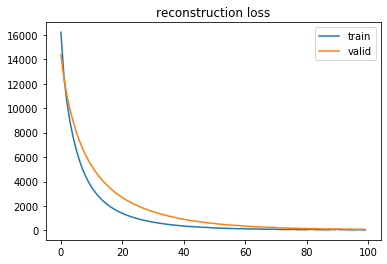

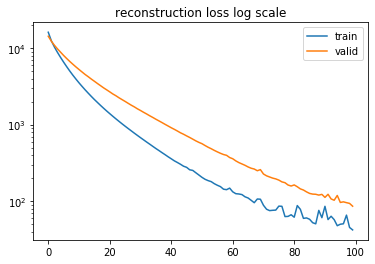

In [24]:
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="valid")
plt.title("reconstruction loss")
plt.legend()
plt.show()

plt.yscale("log")
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="valid")
plt.title("reconstruction loss log scale")
plt.legend()
plt.show()

## KL divergence loss

In [25]:
all_train_loss, all_valid_loss = load_all_losses(name='kl_div')

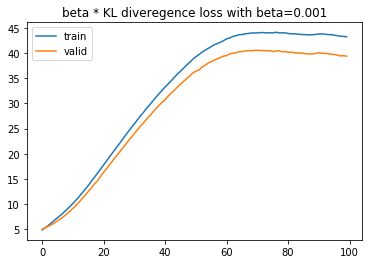

In [26]:
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="valid")
plt.title("beta * KL diveregence loss with beta=" + str(results['config']['model'][model_name]['beta']))
plt.legend()
plt.show()

## Activation statistics

In [27]:
model = configuration.setup_model(results['config'])
model.load_state_dict(torch.load(os.path.join(result_dir, "best_model_" + str(seed) + ".pth.tar")))
valid_loader = configuration.setup_dataloader(results['config'], 'valid')

valid split of size 739 with number of environments 1


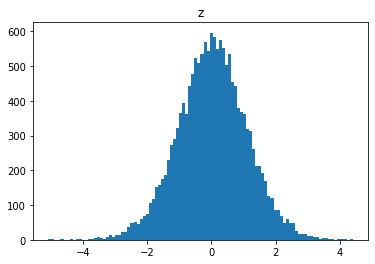

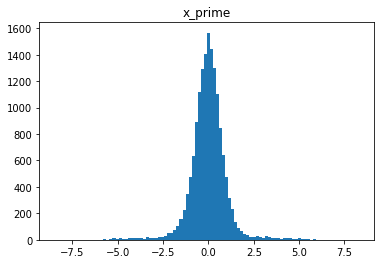

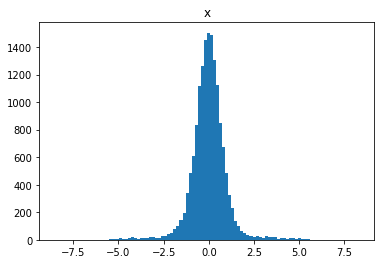

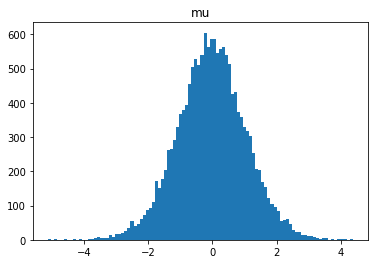

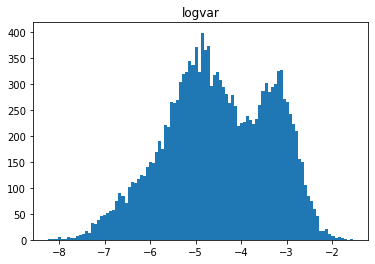

In [28]:
with torch.no_grad():
    for batch_idx, data in enumerate(valid_loader):

        x, fingerprint, compound, line = data

        # Expected to return a dictionary of outputs.
        outputs = model.forward(x, fingerprint, compound, line)
        for key in outputs.keys():
            plt.hist(outputs[key].numpy().reshape(-1), bins=100)
            plt.title(key)
            plt.show()
        break

In [29]:
model

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Dummy()
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=978, out_features=978, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=978, out_features=978, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=978, out_features=978, bias=True)
    )
  )
  (criterion): MSELoss()
)

torch.Size([16, 978])


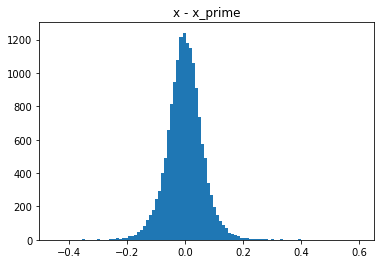

In [31]:
x_minus_x_prime = outputs['x'] - outputs['x_prime']
print(x_minus_x_prime.shape)
plt.hist(x_minus_x_prime.numpy().reshape(-1), bins=100)
plt.title('x - x_prime')
plt.show()